Nach dieser [Quelle](https://www.kaggle.com/code/wissams/titanic-competition-step-by-step-using-xgboost)

**Hat auch gute explorative Datenanalyse!**

In [1]:
import pandas as pd
import numpy as np

# Zeige alle Daten, egal wie groß das DF ist
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Funktionen
def transform_data(df:pd.DataFrame):
    # Fülle die fehlenden Wert in 'Age' auf
    df["Age"] = df["Age"].fillna(df["Age"].mean())
    
    # Fülle fehlende Werte in 'Embarked' auf
    df["Embarked"] = df["Embarked"].fillna("U")
    
    # Fülle fehlende Werte in 'Fare' auf
    df["Fare"] = df["Fare"].fillna(df["Fare"].mean())
    
    # Now the names...
    # First, seperate the first and last name
    df[["LastName", "FirstName_tmp"]] = df["Name"].str.split(",", expand=True)
    
    # Now the salutation forms
    df[["SalutForm","FirstName"]] = df["FirstName_tmp"].str.split(".", n=1, expand=True)
    df["SalutForm"] = df["SalutForm"].str.replace(" ", "")
    title_mapping= {
        "Mr":"Mr",
        "Mrs":"Mrs",
        "Miss":"Miss",
        "Master":"Master",
        "Don":"Rare",
        "Rev":"Rare",
        "Dr":"Rare",
        "Mme":"Mrs",
        "Ms":"Miss",
        "Major":"Rare",
        "Lady":"Rare" ,
        "Sir":"Rare",
        "Mlle":"Miss",
        "Col":"Rare",
        "Capt":"Rare",
        "theCountess":"Rare",
        "Jonkheer":"Rare",
        "Dona":"Rare"
    }
    df["Title"] = df["SalutForm"].map(title_mapping)
    
    # Calc family size
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # Alter gruppieren
    group_limits = [0, 10, 20, 30, 40, 50 , 60, 70, 100]
    groups = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-100"]
    df["AgeGroup"] = pd.cut(df['Age'], bins=group_limits, labels=groups)
    
    # Kartenkosten gruppieren (min:0, max:512.3292, das sind die Quartilsgrenzen unten)
    group_limits = [-1, 7.9104, 14.4542, 31.0, 70, np.inf]
    groups = ["Low", "Medium", "High", "Extreme", "MoreExtreme"]
    df["FareGroup"] = pd.cut(df['Fare'], bins=group_limits, labels=groups)
    
    # Extrahiere den ersten Buchstaben der Kabine (falls nicht vorhanden -> U)
    # U --> Unknown!
    df["CabinLetter"] = df["Cabin"].str[:1]
    df["CabinLetter"].fillna("U", inplace=True)
    
    # Erstelle die Spalte "IsMale", um unnötiges OHE zu vermeiden
    df["IsMale"]= df["Sex"].apply(lambda x: 1 if x=="male" else 0)
    
    # Ermittle die Gruppengröße (Wie viele Passagiere haben diesselbe Ticketnummer?)
    tickets= df.groupby(["Ticket"])[["PassengerId"]].count().rename(columns={"PassengerId": "Count"})
    df["GroupSize"]=df["Ticket"].apply(lambda x: tickets.loc[x, "Count"])
    
    # Erstelle ein paar Interaktionsvariablen
    df["Class+Sex"] = df["Pclass"].astype(str) + "+" + df["Sex"].astype(str)
    df["AgeGroup+Sex"] = df["AgeGroup"].astype(str) + "+" + df["Sex"].astype(str)
    df["AgeGroup+Class"] = df["AgeGroup"].astype(str) + "+" + df["Pclass"].astype(str)
    df["Embarked+Class"] = df["Embarked"].astype(str) + "+" + df["Pclass"].astype(str)
    df["Title+Class"] = df["Title"].astype(str) + "+" + df["Pclass"].astype(str)
    df["FareGroup+Sex"] = df["FareGroup"].astype(str) + "+" + df["Sex"].astype(str)
    df["Embarked+Sex"] = df["Embarked"].astype(str) + "+" + df["Sex"].astype(str)
    df["Embarked+FareGroup"] = df["Embarked"].astype(str) + "+" + df["FareGroup"].astype(str)
    df["CabinLetter+Sex"] = df["CabinLetter"].astype(str) + "+" + df["Sex"].astype(str)
    df["CabinLetter+Class"] = df["CabinLetter"].astype(str) + "+" + df["Pclass"].astype(str)
    

    # Verwerfe nicht benötigte Zeilen
    df = df.drop([
        "PassengerId",
        "FirstName_tmp",
        "Name",
        "Cabin",
        "SibSp",
        "Parch",
        "FirstName",
        "Sex",
        "Ticket",
        "SalutForm"],
        axis=1)
                              
    return df

def group_families_fam_size(df: pd.DataFrame):
    for fam in df["LastName"].unique():
        tmp_df = df.loc[df["LastName"] == fam ]
        
        unique_fam_sizes = tmp_df["FamilySize"].unique()
        
        i = 0
        for size in unique_fam_sizes:
            df.loc[(df["FamilySize"] == size) & (df["LastName"] == fam), "Family"] = f"{fam}_{i}"
            i = i + 1 

In [2]:
from sklearn import compose, impute, linear_model, preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

def prepare_data():

    # Lade den Trainingsdatensatz
    train = pd.read_csv("../data/train.csv")
    # train["IsKaggleTestData"] = False
    
    # Lade den Kaggle Test Datensatz
    # Dieser muss zusammen mit dem Trainingsdatensatz verarbeitet werden, sonst fehlen einige Spalten im Kaggle Testdatensatz!
    X_test_kaggle = pd.read_csv("../data/test.csv")
    _X_test_kaggle = X_test_kaggle.copy()

    # X_test_kaggle["Survived"] = 0 # Dummy damit Pandas keine Zicken macht
    # X_test_kaggle["IsKaggleTestData"] = True
    
    # Kombiniere beide Datensätze, da es ansonsten Probleme mit der Pipeline gibt
    # !!! ACHTUNG !!! DATA LEAKAGE !!!
    # df = pd.concat([train, X_test_kaggle], axis=0)
    
    # Transformiere die Trainingsdaten
    train = transform_data(train)
    
    # Transformiere die Kaggle Testdaten
    X_test_kaggle = transform_data(X_test_kaggle)
    
    # Transformiere die Daten mit der ersten Funktion
    # df = transform_data(df)
    # group_families_fam_size(df)
    # df_for_exploration = df.copy()
    
    # Typisiere die Spalten
    num_cols = ["Age", "Fare", "FamilySize"]
    cat_cols = [
        "Pclass",
        "Embarked",
        "Title",
        "FareGroup",
        "CabinLetter",
        "AgeGroup",
        "Class+Sex",
        "AgeGroup+Sex",
        "AgeGroup+Class",
        "Embarked+Class",
        "Title+Class",
        "FareGroup+Sex",
        "Embarked+Sex",
        "Embarked+FareGroup",
        "CabinLetter+Sex",
        "CabinLetter+Class"
    ]
    dist_col = ["IsMale"]
    
    # Definiere die Pipeline und die verschiedenen Preprocesors
    # numerical_preprocessor = Pipeline(steps=[
    #     ("imputer", impute.SimpleImputer(strategy="mean")),
    #     ("scaler", preprocessing.StandardScaler())
    # ])

    categorical_preprocessor = Pipeline(steps=[
        ("imputer", impute.SimpleImputer(strategy="most_frequent")),
        ("onehot", preprocessing.OneHotEncoder(handle_unknown="error", sparse_output=False)),
    ])

    preprocessor = compose.ColumnTransformer(
        transformers=[
            ("categorical", categorical_preprocessor, cat_cols),
            ("passthrough", "passthrough", dist_col)
        ]
    )
    
    # Löse die Labels von Features ab
    y = train[["Survived"]]
    X = train.drop(["Survived"], axis=1)
    
    # Erstelle ein DF für die explorative Datenanalyse
    df_for_exploration = pd.concat([y, X], axis=1)
    
    # Preprocess die Features
    preprocessor.set_output(transform="pandas")
    X_pipe = preprocessor.fit_transform(X)
    X_kaggle_pipe = preprocessor.fit_transform(X_test_kaggle)
    
    # Erstelle aus den Trainingsfeatures ein weiteren Testdatensatz, der lokal benutzt wird
    X_train, X_test, y_train, y_test = train_test_split(X_pipe, y, test_size=0.2)
    
    # Gebe die lokalen Trainings- und Testdatensätze sowie den Kaggle Testdatensatz zurück
    return X_train, X_test, y_train, y_test, X_kaggle_pipe, _X_test_kaggle, df_for_exploration

In [3]:
X_train, X_test, y_train, y_test, X_test_kaggle_pipe, _X_test_kaggle, df_data_ex = prepare_data()

In [4]:
df_data_ex.head()

,Survived,Pclass,Age,Fare,Embarked,LastName,Title,FamilySize,AgeGroup,FareGroup,CabinLetter,IsMale,GroupSize,Class+Sex,AgeGroup+Sex,AgeGroup+Class,Embarked+Class,Title+Class,FareGroup+Sex,Embarked+Sex,Embarked+FareGroup,CabinLetter+Sex,CabinLetter+Class
0,0,3,22.0,7.2500,S,Braund,Mr,2,20-30,Low,U,1,1,3+male,20-30+male,20-30+3,S+3,Mr+3,Low+male,S+male,S+Low,U+male,U+3
1,1,1,38.0,71.2833,C,Cumings,Mrs,2,30-40,MoreExtreme,C,0,1,1+female,30-40+female,30-40+1,C+1,Mrs+1,MoreExtreme+female,C+female,C+MoreExtreme,C+female,C+1
2,1,3,26.0,7.9250,S,Heikkinen,Miss,1,20-30,Medium,U,0,1,3+female,20-30+female,20-30+3,S+3,Miss+3,Medium+female,S+female,S+Medium,U+female,U+3
3,1,1,35.0,53.1000,S,Futrelle,Mrs,2,30-40,Extreme,C,0,2,1+female,30-40+female,30-40+1,S+1,Mrs+1,Extreme+female,S+female,S+Extreme,C+female,C+1
4,0,3,35.0,8.0500,S,Allen,Mr,1,30-40,Medium,U,1,1,3+male,30-40+male,30-40+3,S+3,Mr+3,Medium+male,S+male,S+Medium,U+male,U+3


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 306 to 189
Columns: 166 entries, categorical__Pclass_1 to passthrough__IsMale
dtypes: float64(165), int64(1)
memory usage: 928.9 KB


In [6]:
X_train.shape

(712, 166)

In [7]:
df_data_ex["Embarked+Class"].value_counts()

S+3    353
S+2    164
S+1    127
C+1     85
Q+3     72
C+3     66
C+2     17
Q+2      3
U+1      2
Q+1      2
Name: Embarked+Class, dtype: int64

<Axes: >

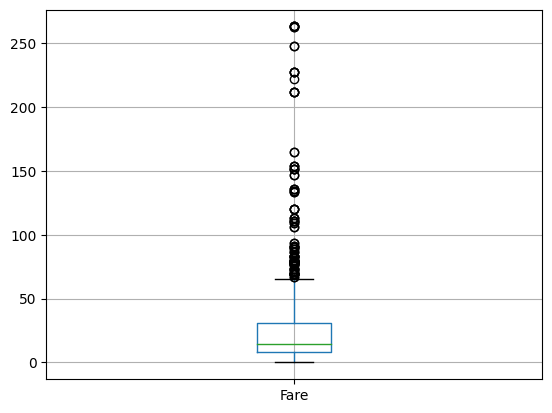

In [8]:
df_data_ex[df_data_ex["Fare"] < 500].boxplot(["Fare"])

In [9]:
df_data_ex.boxplot(["Fare"])

<Axes: >

In [10]:
df_data_ex["FareGroup"].value_counts()

Medium         224
Low            223
High           222
Extreme        117
MoreExtreme    105
Name: FareGroup, dtype: int64

In [11]:
df_data_ex["Fare"].max()

512.3292

In [12]:
# Finde heraus, welche Spalten wenige Passagiere erfassen und lösche diese (sonst könnte es zu Overfitting kommen)
cols_to_drop = []
for col in X_train.columns:
    if "categorical__" in col:
        if X_train[col].sum()/len(X_train) < 0.1:
            cols_to_drop.append(col)
print(f"Es wurden {len(cols_to_drop)} Spalten verworfen")

X_train = X_train.drop(cols_to_drop, axis=1)
X_test = X_test.drop(cols_to_drop, axis=1)
# X_test_kaggle_pipe = X_test_kaggle_pipe.drop(cols_to_drop, axis=1)

Es wurden 117 Spalten verworfen


In [13]:
# Entferne alle Spalten aus dem Kaggle Testdatensatz, die im Trainingsdatensatz nicht benötigt werden
for col in cols_to_drop:
    if col in X_test_kaggle_pipe.columns:
        X_test_kaggle_pipe = X_test_kaggle_pipe.drop([col], axis=1)

In [14]:
# Verwerfe alle Spalten im Kaggle Testdatensatz, die nicht im Trainingsdatensatz auftauchen
for col in X_test_kaggle_pipe.columns:
    if col not in X_train:
        X_test_kaggle_pipe = X_test_kaggle_pipe.drop([col], axis=1)

In [15]:
print("train.shape", X_train.shape)
print("kaggle.shape", X_test_kaggle_pipe.shape)

train.shape (712, 49)
kaggle.shape (418, 49)


In [16]:
for col in X_train.columns:
    if col not in X_test_kaggle_pipe.columns:
        print("Scheiße")

In [17]:
for col in X_test_kaggle_pipe.columns:
    if col not in X_train.columns:
        print("Scheiße")

In [18]:
X_test_kaggle_pipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 49 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   categorical__Pclass_1                      418 non-null    float64
 1   categorical__Pclass_2                      418 non-null    float64
 2   categorical__Pclass_3                      418 non-null    float64
 3   categorical__Embarked_C                    418 non-null    float64
 4   categorical__Embarked_S                    418 non-null    float64
 5   categorical__Title_Miss                    418 non-null    float64
 6   categorical__Title_Mr                      418 non-null    float64
 7   categorical__Title_Mrs                     418 non-null    float64
 8   categorical__FareGroup_Extreme             418 non-null    float64
 9   categorical__FareGroup_High                418 non-null    float64
 10  categorical__FareGroup_Low

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 306 to 189
Data columns (total 49 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   categorical__Pclass_1                      712 non-null    float64
 1   categorical__Pclass_2                      712 non-null    float64
 2   categorical__Pclass_3                      712 non-null    float64
 3   categorical__Embarked_C                    712 non-null    float64
 4   categorical__Embarked_S                    712 non-null    float64
 5   categorical__Title_Miss                    712 non-null    float64
 6   categorical__Title_Mr                      712 non-null    float64
 7   categorical__Title_Mrs                     712 non-null    float64
 8   categorical__FareGroup_Extreme             712 non-null    float64
 9   categorical__FareGroup_High                712 non-null    float64
 10  categorical__FareGroup_L

In [20]:
# raise Exception("STOOOOOOP")


In [21]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [22]:
# Hyperparameter für die Modelle

# Random Forest
rf_params = {
    "n_jobs": -1,
    "n_estimators": 500,
     "warm_start": True, 
     #"max_features": 0.2,
    "max_depth": 6,
    "min_samples_leaf": 2,
    "max_features" : "sqrt",
    "verbose": 0
}

# Extra Trees
et_params = {
    "n_jobs": -1,
    "n_estimators":500,
    # "max_features": 0.5,
    "max_depth": 8,
    "min_samples_leaf": 2,
    "verbose": 0
}

# AdaBoost
ada_params = {
    "n_estimators": 500,
    "learning_rate" : 0.75
}

# Gradient Boosting
gb_params = {
    "n_estimators": 500,
    # "max_features": 0.2,
    "max_depth": 5,
    "min_samples_leaf": 2,
    "verbose": 0
}

# Support Vector Classifier
svc_params = {
    "kernel" : "linear",
    "C" : 0.025
}

bag_svc_params = {
    "estimator": SVC(),
    "n_estimators": 500,
    "max_samples": 50,
    "bootstrap": True,
    "n_jobs": -1
}

bag_rf_params = {
    "estimator": RandomForestClassifier(),
    "n_estimators": 100,
    "max_samples": 200,
    "bootstrap": True,
    "n_jobs": -1
}

bag_dt_params = {
    "estimator": DecisionTreeClassifier(),
    "n_estimators": 100,
    "max_samples": 200,
    "bootstrap": True,
    "n_jobs": -1
}


# für die Grid Search (siehe weiter unten -> XGBoost)
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [1, 3, 5, 7],
    "n_estimators": [50, 100, 150, 200],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 0.1, 1, 10],
    "min_child_weight": [1, 3, 5, 7],
    "early_stopping_rounds": [10, 15, 20]
}


In [23]:
# Create 5 objects that represent our 4 models
rf = RandomForestClassifier(**rf_params)
et = ExtraTreesClassifier(**et_params)
ada = AdaBoostClassifier(**ada_params)
gb = GradientBoostingClassifier(**gb_params)
svc = SVC(**svc_params)
bag_svc = BaggingClassifier(**bag_svc_params)
bag_rf = BaggingClassifier(**bag_rf_params)
bag_dt = BaggingClassifier(**bag_dt_params)

In [24]:
# Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold



cv_strat = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid=param_grid,
    cv=cv_strat,
    verbose=1,
    scoring="accuracy",
    n_jobs=-1,
)

grid_search.fit(X_train, y_train.to_numpy().ravel(), eval_set=[(X_test, y_test)])

Fitting 3 folds for each of 6912 candidates, totalling 20736 fits
[0]	validation_0-logloss:0.64830
[1]	validation_0-logloss:0.61444
[2]	validation_0-logloss:0.58507
[3]	validation_0-logloss:0.56115
[4]	validation_0-logloss:0.53900
[5]	validation_0-logloss:0.52327
[6]	validation_0-logloss:0.51003
[7]	validation_0-logloss:0.49789
[8]	validation_0-logloss:0.48876
[9]	validation_0-logloss:0.48052
[10]	validation_0-logloss:0.47431
[11]	validation_0-logloss:0.46807
[12]	validation_0-logloss:0.46226
[13]	validation_0-logloss:0.45824
[14]	validation_0-logloss:0.45632
[15]	validation_0-logloss:0.45518
[16]	validation_0-logloss:0.45471
[17]	validation_0-logloss:0.45345
[18]	validation_0-logloss:0.45324
[19]	validation_0-logloss:0.45114
[20]	validation_0-logloss:0.45230
[21]	validation_0-logloss:0.45288
[22]	validation_0-logloss:0.45543
[23]	validation_0-logloss:0.45551
[24]	validation_0-logloss:0.45548
[25]	validation_0-logloss:0.45651
[26]	validation_0-logloss:0.45766
[27]	validation_0-logloss:

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_typ...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'early_stopping_rounds': [10, 15, 20],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [1, 3, 5, 7],
                         'min_child_weight': [1, 3, 5, 7],
                         'n_estimators': [50, 100, 150, 200],
                         'reg_alpha': [0, 0.1, 1, 10]},
             scoring='accuracy', verbose=1)

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model = grid_search

# result = cross_val_score(model, X_train, y_train.to_numpy().ravel(), scoring="accuracy")
# mean = sum(result) / len(result)
y_test_predict = model.predict(X_test)

string = ""
# string = f"{string}\nDurc. Accuracy: {mean} (cross val. auf Trainingsdatensatz)"
string = f"{string}\nAccuracy: \t{accuracy_score(y_test, y_test_predict)} (Testdatensatz)"
string = f"{string}\nPrecision: \t{precision_score(y_test, y_test_predict)} (Testdatensatz)"
string = f"{string}\nRecall: \t{recall_score(y_test, y_test_predict)} (Testdatensatz)"
string = f"{string}\nF1 Score: \t{f1_score(y_test, y_test_predict)} (Testdatensatz)"
print("Beste Parameter: ", grid_search.best_params_)
print(string, "\n")

result_text = f"GridSearch\nBeste Parameter für GridSearch: {grid_search.best_params_}"
result_text = f"{result_text}\n{string}\n"

Beste Parameter:  {'colsample_bytree': 0.8, 'early_stopping_rounds': 10, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 50, 'reg_alpha': 0}

Accuracy: 	0.7877094972067039 (Testdatensatz)
Precision: 	0.696969696969697 (Testdatensatz)
Recall: 	0.71875 (Testdatensatz)
F1 Score: 	0.7076923076923077 (Testdatensatz) 



In [26]:
models = {
    "RandomForest": rf,
    "ExtraTrees": et,
    "AdaBoost": ada,
    "GradientBoosting": gb,
    "SVC": svc,
    "Bagging_SVC": bag_svc,
    "Bagging_RandomForest": bag_rf,
    "Bagging_DecisionTree": bag_dt,
    # "GridSearchBest": grid_search,
}

In [27]:
# Trainiere sie alle
for model in models.keys():
    models[model].fit(X_train, y_train.to_numpy().ravel())

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime

for name, model in models.items():
    result = cross_val_score(model, X_train, y_train.to_numpy().ravel(), scoring="accuracy")
    mean = sum(result) / len(result)
    y_test_predict = model.predict(X_test)

    
    string = f"Modell: {name}"
    string = f"{string}\nDurc. Accuracy: {mean} (cross val. auf Trainingsdatensatz)"
    string = f"{string}\nAccuracy: \t{accuracy_score(y_test, y_test_predict)} (Testdatensatz)"
    string = f"{string}\nPrecision: \t{precision_score(y_test, y_test_predict)} (Testdatensatz)"
    string = f"{string}\nRecall: \t{recall_score(y_test, y_test_predict)} (Testdatensatz)"
    string = f"{string}\nF1 Score: \t{f1_score(y_test, y_test_predict)} (Testdatensatz)"
    print(string, "\n")
    
    result_text = f"{result_text}\n{string}\n"
    
with open(f"../submissions/{datetime.today().strftime('%Y-%m-%d %H_%M_%S')}_last values.txt", "w") as file:
    file.write(result_text)
    file.close()


Modell: RandomForest
Durc. Accuracy: 0.7977445090121147 (cross val. auf Trainingsdatensatz)
Accuracy: 	0.8044692737430168 (Testdatensatz)
Precision: 	0.7543859649122807 (Testdatensatz)
Recall: 	0.671875 (Testdatensatz)
F1 Score: 	0.7107438016528924 (Testdatensatz) 

Modell: ExtraTrees
Durc. Accuracy: 0.8061262680980992 (cross val. auf Trainingsdatensatz)
Accuracy: 	0.8100558659217877 (Testdatensatz)
Precision: 	0.75 (Testdatensatz)
Recall: 	0.703125 (Testdatensatz)
F1 Score: 	0.7258064516129032 (Testdatensatz) 

Modell: AdaBoost
Durc. Accuracy: 0.7949374569092879 (cross val. auf Trainingsdatensatz)
Accuracy: 	0.8156424581005587 (Testdatensatz)
Precision: 	0.7818181818181819 (Testdatensatz)
Recall: 	0.671875 (Testdatensatz)
F1 Score: 	0.7226890756302521 (Testdatensatz) 

Modell: GradientBoosting
Durc. Accuracy: 0.8202206244459764 (cross val. auf Trainingsdatensatz)
Accuracy: 	0.7932960893854749 (Testdatensatz)
Precision: 	0.7076923076923077 (Testdatensatz)
Recall: 	0.71875 (Testdatensat

In [29]:
# Ersetze die Grid Search durch das beste Modell
models["GridSearchBest"] = grid_search.best_estimator_

In [30]:
# Vorhersagen für Kaggle

name = "GridSearchBest"

# Check, ob der Name im Dict ist
if name not in models.keys():
    raise KeyError(f"Das Modell {name} ist nicht im Dictionary!")


preds_kaggle = models[name].predict(X_test_kaggle_pipe)
output = pd.DataFrame({"PassengerId": _X_test_kaggle["PassengerId"], "Survived": preds_kaggle})
output_path = f"../submissions/{datetime.today().strftime('%Y-%m-%d %H_%M_%S')} {name}.csv"
output.to_csv(output_path, index=False)